In [30]:
import os
import codecs

import numpy as np

import matplotlib
import matplotlib.pyplot as plt, mpld3 
# The mpld3 project brings together Matplotlib, the popular Python-based graphing 
#library, and D3js, the popular JavaScript library for creating interactive data visualizations for the web.
mpld3.enable_notebook()

import spacy
# precisa instalar e baixar antes: 
# para windows procurar hunspell em: https://sourceforge.net/projects/ezwinports/files/
# e depois colocar o executável no PATH do windows
# e só depois pip install hunspell
import hunspell 
import pandas as pd

import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from gensim.models import KeyedVectors

EMBEDDING_SIZE = 300
# Dados relativos ao artigo: https://sites.icmc.usp.br/taspardo/PROPOR2018-MonteiroEtAl.pdf

In [31]:
# no drive do curso, na pasta da aula03, o modelo do word2vec já treinado está lá
model = KeyedVectors.load_word2vec_format('../aula03/vectors-wikipt.bin',binary=True)

/usr/local/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [32]:
def corpus_arquivos(data_dir):
    
    lst_files = []
    for dirpath, dirnames, filenames in os.walk(data_dir):
        for f in filenames:
            if f.endswith(".txt"):
                lst_files.append(os.path.join(dirpath, f))
                
    return lst_files

In [33]:
# pegando os arquivos fakes
lst_fake = corpus_arquivos("Fake.Br Corpus/full_texts/fake/")

# pegando os arquivos verdadeiros
lst_verdadeiros = corpus_arquivos("Fake.Br Corpus/full_texts/true/")

In [34]:
# leitura dos arquivos 
# classes 1: fake 0: true
target = []
file_names = []
text_news = []
for news_file in lst_fake:
    file_names.append(news_file)
    text_news.append(codecs.open(news_file, "r",encoding="iso8859-1").read())
    target.append(1)
    
#text_news = text_news[:100]
#target = target[:100]
#file_names = file_names[:100]

for news_file in lst_verdadeiros:
    file_names.append(news_file)
    text_news.append(codecs.open(news_file, "r", encoding="iso8859-1").read())
    target.append(0)
    
#text_news = text_news[:200]
#target = target[:200]
#file_names = file_names[:200]

print(len(text_news))

7200


# Pré-processamento de cada texto

In [35]:
import nltk
# podemos remover '' e `` tambem, eles apareceram como muito frequentes em 
# uma primeira execucao então voltei e acrecentei eles aqui
stopwords = nltk.corpus.stopwords.words('portuguese') + ["''","``"]

In [36]:
# cada documento será tokenizado e sera pre-processado
# apos isso, calculamos a media dos seus word embeddings e assim
# temos a representação do documento
def load_doc(doc_txt):
    
    tok_lst = nltk.word_tokenize(doc_txt)
    tok_lst = [tok for tok in tok_lst if tok not in stopwords and len(tok) > 1]
    
    ntok = 0
    doc = np.zeros((EMBEDDING_SIZE,))
    for tok in tok_lst:
        # lembrando que nem todo token existe no modelo
        # se eu nao fizer essa checagem, quando chegar em algum token
        # e ele não existir no modelo, vai dar uma execção e o programa para
        if tok in model:
            doc = np.add(doc, model[tok]) # doc = doc + vec_word
            ntok += 1
            
    doc = doc / ntok
    return doc

In [37]:
def load_docs():
    model_news = []
    for idx,text in enumerate(text_news):
        doc = load_doc(text)
        model_news.append(doc)
    return model_news

In [38]:
model_news = load_docs()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [10]:
# vamos checar o primeiro documento
# ele deve ser similar a um vetor de word embeddings, pois é apenas uma média 
# de um conjunto deles
# aqui já extraímos nossas "características", pois as mesmas foram extraídas quando 
# treinamos um modelo word2vec. Aqui estamos aplicando
print(model_news[0])

[-0.10329939 -0.6493796   0.18785365  0.13517583  0.36822725 -0.23168206
 -0.0734484   0.10779928 -0.23836241 -0.06086857 -0.25358219  0.23930267
 -0.06454199 -0.19459169 -0.5108179   0.16910156  0.46436337  0.20963234
  0.16621622 -0.51314796 -0.34098787 -0.34035878  0.07233587 -0.00942438
 -0.03531856 -0.4512815  -0.14308334 -0.23167186 -0.22263706  0.00522353
 -0.07869977  0.014447    0.44143846 -0.10018693  0.27168348 -0.0434124
  0.03259591 -0.27085267  0.28697743 -0.4620764   0.18025517  0.27388245
 -0.20063055 -0.32280783 -0.0336979  -0.61695821 -0.01721188 -0.34883268
 -0.25613283 -0.45791258 -0.27792307 -0.07517489  0.12017255  0.1229793
  0.06450439  0.16924741  0.09649869 -0.18902074 -0.01143713 -0.09900403
  0.12795263  0.02338958  0.04236593  0.06108112 -0.11466469 -0.38242935
 -0.00276243  0.0233325   0.34845033 -0.28980454 -0.27677411 -0.09975784
  0.22752251  0.29979651  0.28726514  0.43534526  0.09688211  0.26385043
  0.33770339 -0.19543962  0.07922046 -0.24729551  0.2

In [39]:
# vamos ver se o tamanho condiz com a quantidade de documentos
print(len(model_news))

7200


# Visualização de dados

In [40]:
from sklearn import decomposition

In [13]:
pca = decomposition.PCA(n_components=2)

In [14]:
pc = pca.fit_transform(model_news)

In [15]:
pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2'])
pc_df['Cluster'] = target
pc_df.head()

,PC1,PC2,Cluster
0,1.653331,1.113085,1
1,-0.689395,0.913771,1
2,-1.275331,0.348836,1
3,2.341983,-0.840065,1
4,-3.190569,-0.194305,1


In [16]:
# compare com os resultados do pca do outro modelo
print(pca.explained_variance_ratio_)

[0.19312658 0.10918024]


/usr/local/anaconda3/lib/python3.6/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/usr/local/anaconda3/lib/python3.6/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)


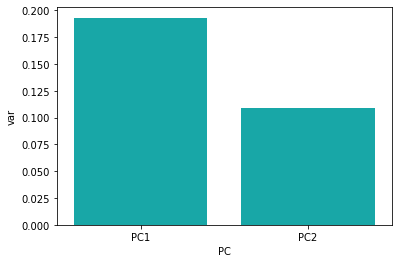

In [17]:
# compare com o gráfico do outro modelo
df_explain = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2']})
sns.barplot(x='PC',y="var", 
           data=df_explain, color="c");

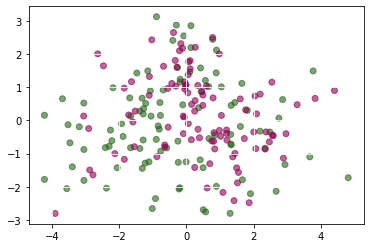

In [18]:
# Compare com o gráfico da outra extração de features

# para evitar apagar plots anteriores, podemos usar o subblot
# Retorna o objeto da figura e também o eixo (axes) onde sera plotado
# fica mais facil de manipular o nosso grafico tbm
fig, ax = plt.subplots()

# coordenadas x
# coordenadas y
# c: sequencia de cores, no caso associamos a sequência de cores a nossa classe (fake ou não)
# alpha: O valor de opacidade das cores, entre 0 (transparente) e 1 (totalmente opaco).
# cmap -> color map: mapa de cores. Opções: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
scatter = ax.scatter(pc_df.PC1, pc_df.PC2,
                     c=pc_df.Cluster, 
                     alpha=0.6,
                     cmap=plt.get_cmap("PiYG"))
plt.savefig('pca_fakenews_w2v_200.png')

# opção caso queira colocar uma "grade" no seu gráfico    
ax.grid(color='white', linestyle='solid')

N = len(pc_df)
labels = ["Linha %d" % d for d in range(N)]

fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels)

mpld3.plugins.connect(fig, tooltip)

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [20]:
df_tsne = tsne.fit_transform(model_news)

/usr/local/anaconda3/lib/python3.6/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)


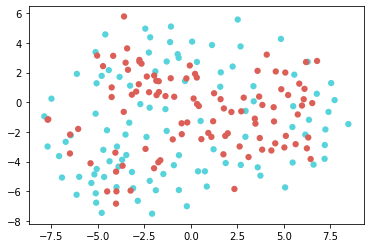

In [21]:
# Compare com o gráfico do PCA acima e também com o do 
# tsne do outro
ax = plt.subplot()

colors_tsne = np.array(target)
# duas classes apenas
num_classes = len(np.unique(target))
# pegando emprestado do seaborn uma paleta de cores
palette = np.array(sns.color_palette("hls", num_classes))

sc = ax.scatter(df_tsne[:,0], df_tsne[:,1], lw=0, s=40, c=palette[colors_tsne.astype(np.int)])
plt.savefig('tsne_fakenews_w2v_200.png')

fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels)

mpld3.plugins.connect(fig, tooltip)

# Classificando os nossos dados

In [44]:
# vamos usar a validação cruzada com 5 folds, assim como no artigo
from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle

df = pd.DataFrame(model_news)
df['target'] = target

df = df.sample(frac=1,random_state=0)

df.head()
X = df.drop('target', 1)
y = df.target

In [45]:
clf = svm.SVC() # vamos usar os parâmetros que são default

In [47]:
scores = cross_validate(clf, X, y, cv=5, scoring=['accuracy','f1','precision','recall'])

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [25]:
# vamos imprimir os nosso scores para cada fold
for m in scores:
    print(m, np.mean(scores[m]))

fit_time 0.0205899715423584
score_time 0.018171977996826173
test_accuracy 0.8099999999999999
train_accuracy 0.86625
test_f1 0.7839325567625425
train_f1 0.8555321762012775
test_precision 0.9077380952380952
train_precision 0.9283646701557149
test_recall 0.7
train_recall 0.795


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_f1'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/sklea

In [48]:
# agora vamos testar com o classificador que o artigo usou
# que tbm usou com os parâmetros padroes
clf2 = svm.LinearSVC()
scores = cross_validate(clf2, X, y, cv=5, scoring=['accuracy','f1','precision','recall'])

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [27]:
# vamos olhar nossos resultados
# vamos imprimir os nosso scores para cada fold

# aqui o recall aumentou e a precisao caiu, mas o nosso f1 aumentou um pouco
for m in scores:
    print(m, np.mean(scores[m]))

fit_time 0.027626228332519532
score_time 0.011694955825805663
test_accuracy 1.0
train_accuracy 1.0
test_f1 1.0
train_f1 1.0
test_precision 1.0
train_precision 1.0
test_recall 1.0
train_recall 1.0


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_f1'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/sklea

In [49]:
# Sera que um metodo ensemble pode se dar melhor?
clf3 = RandomForestClassifier(n_estimators=3)
scores = cross_validate(clf3, X, y, cv=5, scoring=['accuracy','f1','precision','recall'])

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [29]:
# vamos olhar nossos resultados
# vamos imprimir os nosso scores para cada fold

# olha só que legal, alcançamos resultados ainda melhores que o do artigo com um ensemble
# contudo, lembrando que temos apenas 200 documentos!
for m in scores:
    print(m, np.mean(scores[m]))

fit_time 0.019282150268554687
score_time 0.029843902587890624
test_accuracy 0.765
train_accuracy 0.94625
test_f1 0.7611103786713543
train_f1 0.9458061002178649
test_precision 0.7604033613445378
train_precision 0.9500083528232542
test_recall 0.7699999999999999
train_recall 0.9424999999999999


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_f1'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/sklea